## Overview

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# maximum nr of frames to process
maxFrames =120
# the size of the sliding window
windowSize = 30
# the magnifaction factor
factor = 20
# the fps used for the bandpass
fpsForBandPass = 600 # use -1 for input video fps
# low ideal filter
lowFreq = 72
# high ideal filter
highFreq = 92
# output video filename

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import os, sys
sys.path.append('..')
from phasebasedMoMag import phaseBasedMagnify

from perceptual.filterbank import *
import cv2
# determine what OpenCV version we are using
try:
    import cv2.cv as cv
    USE_CV2 = True
except ImportError:
    # OpenCV 3.x does not have cv2.cv submodule
    USE_CV2 = False
    
import sys
import numpy as np
from pyr2arr import Pyramid2arr
from temporal_filters import IdealFilterWindowed, ButterBandpassFilter

In [4]:
from pathlib import Path
video_folder = Path('..') / 'media'
out_folder = Path('.')

In [5]:
video_paths = list(video_folder.glob('*.mp4'))
vidFname = video_paths[0]
vidFnameOut = out_folder / '{}-Mag{}Ideal-lo{}-hi{}.mp4'.format(vidFname.stem, factor, lowFreq, highFreq)

In [6]:
steer = Steerable(5)
pyArr = Pyramid2arr(steer)
print "Reading:", vidFname,

# get vid properties
vidReader = cv2.VideoCapture(str(vidFname))
if USE_CV2:
    # OpenCV 2.x interface
    vidFrames = int(vidReader.get(cv.CV_CAP_PROP_FRAME_COUNT))    
    width = int(vidReader.get(cv.CV_CAP_PROP_FRAME_WIDTH))
    height = int(vidReader.get(cv.CV_CAP_PROP_FRAME_HEIGHT))
    fps = int(vidReader.get(cv.CV_CAP_PROP_FPS))
    func_fourcc = cv.CV_FOURCC
else:
    # OpenCV 3.x interface
    vidFrames = int(vidReader.get(cv2.CAP_PROP_FRAME_COUNT))    
    width = int(vidReader.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vidReader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(vidReader.get(cv2.CAP_PROP_FPS))
    func_fourcc = cv2.VideoWriter_fourcc

if np.isnan(fps):
    fps = 30

print ' %d frames' % vidFrames,
print ' (%d x %d)' % (width, height),
print ' FPS:%d' % fps

Reading: ../media/guitar.mp4  300 frames  (432 x 192)  FPS:29


In [7]:
# how many frames
nrFrames = min(vidFrames, maxFrames)

# read video
print steer.height, steer.nbands

# setup temporal filter
filter = IdealFilterWindowed(windowSize, lowFreq, highFreq, fps=fpsForBandPass, outfun=lambda x: x[0])
#filter = ButterBandpassFilter(1, lowFreq, highFreq, fps=fpsForBandPass)

5 4


In [8]:
def add_frame():
    # read frame
    _, im = vidReader.read()

    if im is None:
        # if unexpected, quit
        raise ValueError('Premature ending')

    # convert to gray image
    if len(im.shape) > 2:
        grayIm = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    else:
        # already a grayscale image?
        grayIm = im

    # get coeffs for pyramid
    coeff = steer.buildSCFpyr(grayIm)

    # add image pyramid to video array
    # NOTE: on first frame, this will init rotating array to store the pyramid coeffs                 
    arr = pyArr.p2a(coeff)

    phases = np.angle(arr)

    # add to temporal filter
    filter.update([phases])
    return im, phases

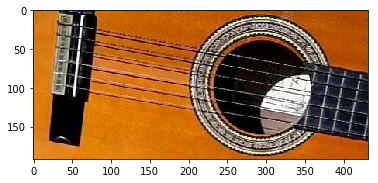

In [9]:
for _ in range(60):
    add_frame();
im, phases = add_frame()
plt.imshow(im[:,:,::-1])

In [10]:
filteredPhases = filter.next()

# motion magnification
magnifiedPhases = (phases - filteredPhases) + filteredPhases*factor

# create new array
newArr = np.abs(arr) * np.exp(magnifiedPhases * 1j)

# create pyramid coeffs     
newCoeff = pyArr.a2p(newArr)

# reconstruct pyramid
out = steer.reconSCFpyr(newCoeff)

NameError: name 'arr' is not defined

In [ ]:
# clip values out of range
out[out>255] = 255
out[out<0] = 0

# make a RGB image
rgbIm = np.empty( (out.shape[0], out.shape[1], 3 ) )
rgbIm[:,:,0] = out
rgbIm[:,:,1] = out
rgbIm[:,:,2] = out

#write to disk
res = cv2.convertScaleAbs(rgbIm)

In [ ]:
plt.imshow(res[:, :, ::-1])

In [ ]:
recon_frames = []
while True:
    try:
        filteredPhases = filter.next()
    except StopIteration:
        break

    # motion magnification
    magnifiedPhases = (phases - filteredPhases) + filteredPhases*factor

    # create new array
    newArr = np.abs(arr) * np.exp(magnifiedPhases * 1j)

    # create pyramid coeffs     
    newCoeff = pyArr.a2p(newArr)

    # reconstruct pyramid
    out = steer.reconSCFpyr(newCoeff)
    # clip values out of range
    out[out>255] = 255
    out[out<0] = 0

    # make a RGB image
    rgbIm = np.empty( (out.shape[0], out.shape[1], 3 ) )
    rgbIm[:,:,0] = out
    rgbIm[:,:,1] = out
    rgbIm[:,:,2] = out

    #write to disk
    recon_frames += [cv2.convertScaleAbs(rgbIm)]

In [ ]:
from skimage.util import montage

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(20, 20))
ax1.imshow(montage(np.stack([x[:, :, 0] for x in recon_frames], 0)), cmap='gray')

In [11]:
phaseBasedMagnify(str(vidFname), str(vidFnameOut), 
                      maxFrames, windowSize, factor, fpsForBandPass, lowFreq, highFreq)

Reading: ../media/guitar.mp4  300 frames  (432 x 192)  FPS:29
Writing: guitar-Mag20Ideal-lo72-hi92.mp4
FrameNr: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 * (48, 144, 108, 324)
(24, 72, 54, 162)
(12, 36, 27, 81)
30 * (48, 144, 108, 324)
(24, 72, 54, 162)
(12, 36, 27, 81)
31 * (48, 144, 108, 324)
(24, 72, 54, 162)
(12, 36, 27, 81)
32 * (48, 144, 108, 324)
(24, 72, 54, 162)
(12, 36, 27, 81)
33 * (48, 144, 108, 324)
(24, 72, 54, 162)
(12, 36, 27, 81)
34 * (48, 144, 108, 324)
(24, 72, 54, 162)
(12, 36, 27, 81)
35 * (48, 144, 108, 324)
(24, 72, 54, 162)
(12, 36, 27, 81)
36 * (48, 144, 108, 324)
(24, 72, 54, 162)
(12, 36, 27, 81)
37 * (48, 144, 108, 324)
(24, 72, 54, 162)
(12, 36, 27, 81)
38 * (48, 144, 108, 324)
(24, 72, 54, 162)
(12, 36, 27, 81)
39 * (48, 144, 108, 324)
(24, 72, 54, 162)
(12, 36, 27, 81)
40 * (48, 144, 108, 324)
(24, 72, 54, 162)
(12, 36, 27, 81)
41 * (48, 144, 108, 324)
(24, 72, 54, 162)
(12, 36, 27, 81)
42 * (48, 144, 108, 324)
(24, 7